2018 Aug 29<br>
The extremely short and low-inclination transit for Kepler-76 b seems to require a fairly high super-sample factor to accurately model the in/egress. I'm exploring how much difference there is using different super-sample factors in this notebook.

In [4]:
%matplotlib inline
import time as tm

import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from numpy.random import normal

from astropy import units as u

from lightkurve import KeplerLightCurveFile

from PyAstronomy.modelSuite import forTrans as ft

from evilmc import evparams, evmodel, convert_Kz
from variable_eclipses_utils import retreive_data
from transit_utils import bindata

from copy import deepcopy

KIC = 4570949

In [5]:
# The system parameters as reported in Faigler et al. (2013) --
#  http://iopscience.iop.org/article/10.1088/0004-637X/771/1/26/meta
a = 1./0.221 #± 0.003
b = 0.944 # ± 0.011
inc = 78.0 # ± 0.2
per = 1.54492875*u.day # ± 0.00000027
Kz_m_per_s = 308. # ± 20.
Kz = convert_Kz(Kz=Kz_m_per_s) # convert to fraction of the speed of light

Mp = 2.00*u.jupiterMass # ± 0.26
Rp_over_a = 0.0214 # ± 0.0008
Rp_over_Rs = Rp_over_a*a
Ms = 1.2*u.solMass # ± 0.2
q = (Mp.to('kg')/Ms.to('kg')).value

vsini = 6500.*u.m/u.s # ± 2000
Rs = 1.32*u.solRad #± 0.08
Omegas = vsini.to('m/s')/Rs.to('m')*per.to('s') # stellar rotation state - very little effect, so chosen arbitrarily

Ts = 6300. # ± 200
Faigler_T0 = (737.49 + 2455000. - 2454833.) % per.to('day').value # ±0.19
T0 = 0.68508434

coeffs = [0.313, 0.304]

Aplanet = 50.4e-6 # ± 2.0
F0 = 50.4e-6 # ± 2.0 -- overall shift in light curve, which is arbitrary
phase_shift = 10.3/360. # ± 2.0 - convert phase shift angle from degrees to orbital phase

beta = 0.0716671 # Interpolation from among the values reported in Claret & Bloemen (2011) A&A 529, 75

# Save parameters to an evilmc parameters object
saved_ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs, limb_dark="quadratic", b=b, 
                    F0=F0, Aplanet=Aplanet, phase_shift=phase_shift, beta=beta, q=q, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], 
                    u=coeffs)

print(Rp_over_a/np.pi*per.to('minute'))

15.1542639704 min


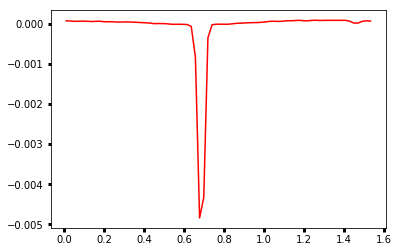

In [6]:
# Fit folded transit
time, flux, filtered_time, filtered_flux = retreive_data(saved_ep.per, num_periods=3, 
                                                         KIC=KIC, params=saved_ep)
folded_time = filtered_time % saved_ep.per

binned_time, binned_flux, binned_err = bindata(folded_time, filtered_flux, binsize=30./60./24.)
#plt.plot(folded_time, filtered_flux, 'b.')
plt.plot(binned_time, binned_flux, 'r')

In [27]:
# Fit the EVIL-MC curve, holding constant the transit parameters
def fit_EVILMC(time, supersample_factor):
    em = evmodel(time, saved_ep, supersample_factor=supersample_factor, exp_time=30./60./24.)
    
    return em.all_signals()

CPU times: user 1.67 s, sys: 870 ms, total: 2.54 s
Wall time: 2.54 s
(150, 0.0)
CPU times: user 1.15 s, sys: 597 ms, total: 1.74 s
Wall time: 1.74 s
(100, 2.5872584443743752e-06)
CPU times: user 815 ms, sys: 365 ms, total: 1.18 s
Wall time: 1.18 s
(70, 5.925349364106053e-06)
CPU times: user 596 ms, sys: 296 ms, total: 892 ms
Wall time: 892 ms
(50, 1.0421229455851821e-05)
CPU times: user 336 ms, sys: 109 ms, total: 445 ms
Wall time: 444 ms
(30, 2.1069408779510212e-05)
CPU times: user 245 ms, sys: 113 ms, total: 358 ms
Wall time: 357 ms
(20, 3.4680628966457516e-05)
CPU times: user 107 ms, sys: 30.6 ms, total: 138 ms
Wall time: 138 ms
(10, 7.769768131395192e-05)
CPU times: user 45.7 ms, sys: 12.3 ms, total: 58 ms
Wall time: 57.9 ms
(5, 0.00017573972255352293)
CPU times: user 40.3 ms, sys: 8.72 ms, total: 49.1 ms
Wall time: 48.9 ms
(3, 0.0003162702295512693)
CPU times: user 11.9 ms, sys: 4 ms, total: 15.9 ms
Wall time: 15.8 ms
(1, 0.0005759521370592266)


(0.6, 0.8)

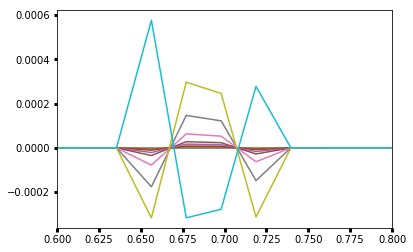

In [28]:
supersample_factors = [150, 100, 70, 50, 30, 20, 10, 5, 3, 1]
sig = np.zeros((len(supersample_factors), len(binned_time)))

for i in range(len(supersample_factors)):
    %time sig[i,:] = fit_EVILMC(binned_time, supersample_factors[i])
    resid = sig[i,:] - sig[0,:]
    plt.plot(binned_time, resid)
    
    print(supersample_factors[i], np.max(np.abs(resid)))

plt.xlim([0.6, 0.8])

(100, 0.0)
(70, 5.598968138742673e-06)
(50, 1.3024522917353884e-05)
(30, 3.0488570961426098e-05)
(20, 5.2553831728196186e-05)
(10, 0.00012027893393852431)
(5, 0.00023288306869943907)
(3, 0.00035003909441081935)
(1, 0.001536319431623974)


(0.6, 0.8)

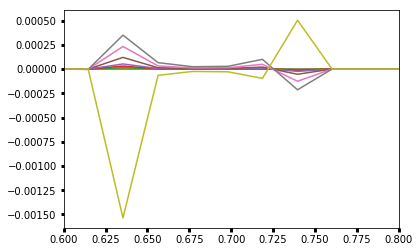

In [7]:
# Fit the EVIL-MC curve, holding constant the transit parameters
def other_fit_EVILMC(time, supersample_factor):
    ep = deepcopy(saved_ep)
    ep.b = 0.
    
    em = evmodel(time, ep, supersample_factor=supersample_factor, exp_time=30./60./24.)
    
    return em.all_signals()

supersample_factors = [100, 70, 50, 30, 20, 10, 5, 3, 1]
sig = np.zeros((len(supersample_factors), len(binned_time)))

for i in range(len(supersample_factors)):
    sig[i,:] = other_fit_EVILMC(binned_time, supersample_factors[i])
    
    resid = sig[i,:] - sig[0,:]
    plt.plot(binned_time, resid)
    
    print(supersample_factors[i], np.max(np.abs(resid)))

plt.xlim([0.6, 0.8])

In [48]:
# Check transit ephemeris using ONLY the transit signal, not evilmc, just to speed up the calculation
def MA_lightcurve(time, supersample_factor):
    
    exp_time = 30./60./24.
    
    model = ft.MandelAgolLC(orbit="circular", ld="quad")

    # Set parameters
    model["per"] = saved_ep.per
    model["i"] = 90.
    model["a"] = saved_ep.a
    model["T0"] = saved_ep.T0
    model["p"] = saved_ep.p
    model["linLimb"] = saved_ep.u[0]
    model["quadLimb"] = saved_ep.u[1]
    model["b"] = 0.

    # Consider finite exposure time
    time_supersample = time
    if(supersample_factor > 1):
        time_offsets = np.linspace(-exp_time/2., exp_time/2., supersample_factor)
        time_supersample = (time_offsets + time.reshape(time.size, 1)).flatten()
    
    ret = model.evaluate(time_supersample)
    
    if(supersample_factor > 1):
        ret = np.mean(ret.reshape(-1, supersample_factor), axis=1)
        
    ret -= 1.
        
    return ret

(100, 0.0)
(70, 5.5986719449396816e-06)
(50, 1.3023827770242136e-05)
(30, 3.048692658480512e-05)
(20, 5.255096335687881e-05)
(10, 0.0001202721216657654)
(5, 0.00023286689001944527)
(3, 0.0003500060564900487)
(1, 0.00153628501952785)


(0.6, 0.8)

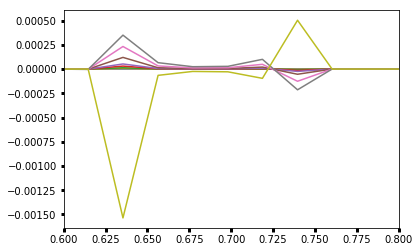

In [49]:
supersample_factors = [100, 70, 50, 30, 20, 10, 5, 3, 1]
sig = np.zeros((len(supersample_factors), len(binned_time)))

for i in range(len(supersample_factors)):
    sig[i,:] = MA_lightcurve(binned_time, supersample_factors[i])
    
    resid = sig[i,:] - sig[0,:]
    plt.plot(binned_time, resid)
    
    print(supersample_factors[i], np.max(np.abs(resid)))

plt.xlim([0.6, 0.8])

---

2018 Sep 17<br>
Next, I'm going to explore how accurately I can recover an eclipse depth when I take a certain super-sample factor.

In [7]:
def fit_eclipse(time, cur_semi, cur_p, cur_imp, cur_depth, supersample_factor=100, exp_time=30./60./24.):
    cur_ep = evparams(per=saved_ep.per, a=cur_semi, T0=saved_ep.T0, p=cur_p, limb_dark="quadratic", 
                      b=cur_imp, beta=saved_ep.beta, Ts=Ts, Ws=[0.,0., Omegas], u=coeffs,
                      q=saved_ep.q, Kz=saved_ep.Kz, F0=saved_ep.F0, Aplanet=saved_ep.Aplanet, 
                      phase_shift=saved_ep.phase_shift)

    em = evmodel(time, cur_ep, supersample_factor=supersample_factor, exp_time=exp_time)
    
    return em.calc_eclipse(cur_depth)

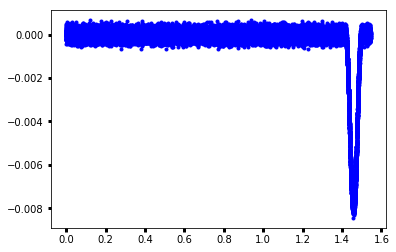

In [8]:
unbinned_noise = 170e-6 # based on Analysis_of_Kepler76b.ipynb as of 2018 Sep 11

# Let's see how long it takes to run EVIL-MC for the full dataset
synthetic_eclipse = fit_eclipse(folded_time, saved_ep.a, saved_ep.p, saved_ep.b, 100e-4)
noisy_synthetic_eclipse = synthetic_eclipse + normal(size=len(synthetic_eclipse), scale=unbinned_noise)
plt.plot(folded_time, noisy_synthetic_eclipse, 'b.')